In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 30.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from rdkit.Chem import QED
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Chem import FilterCatalog
from rdkit import DataStructs
from rdkit.Chem import AllChem

In [ ]:
df = pd.read_csv('‘Adenosine_receptor_a2a_human.tsv', sep='\t')

In [ ]:
#отберем только те записи, которые соответствуют человеческому рецептору
df = df[df['Target Source Organism According to Curator or DataSource'] == 'Homo sapiens']

In [ ]:
#так как идентификаторы InChI уникальны, будем использовать их для поиска дубликатов
df = df.drop_duplicates(subset='Ligand InChI')

In [ ]:
#отберем лиганды с известными константами ингибирования или IC50
mask = (df['Ki (nM)'].notna()) | (df['IC50 (nM)'].notna())
df = df.loc[mask, :]

In [ ]:
#отберем колонки из исходного датасета
columns_to_choose = ['Ligand SMILES', 'Ligand InChI', 'BindingDB Ligand Name', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']
df_processed = df[columns_to_choose]

In [ ]:
#Найдем дескрипторы для данных лигандов
df_descr = df_processed['Ligand SMILES'].apply(lambda x: Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(x)))
descriptors = df_descr.apply(pd.Series)
descriptors = pd.concat([df_processed.loc[:, columns_to_choose],descriptors], axis=1)

In [ ]:
#Будем считать, что Ki и IC50 приблизительно равны и объединим данные в одну колонку (делаем так, потому что было обнаружено, что для каждой записи известна только либо Ki, либо IC50)
temp = descriptors
temp['IC50 (nM)'] = temp['IC50 (nM)'].combine_first(temp['Ki (nM)']) #объединяем значения Ki и IC50 в одну колонку
temp = temp.drop(['Ki (nM)'], axis=1)
mask = (descriptors["IC50 (nM)"].str.contains("<")) | (descriptors["IC50 (nM)"].str.contains(">"))
temp2 = temp[~mask]

In [ ]:
temp2['IC50 (nM)'] = temp2['IC50 (nM)'].apply(float).apply(lambda x: x * 10e-9).apply(math.log10).apply(lambda x: x * (-1))
temp2 = temp2.rename({'IC50 (nM)': 'pIC50 (nM)'}, axis=1)

/tmp/ipython-input-34-3180214884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['IC50 (nM)'] = temp2['IC50 (nM)'].apply(float).apply(lambda x: x * 10e-9).apply(math.log10).apply(lambda x: x * (-1))


In [ ]:
#удалим колонки, в которых нулевые значения сооответствуют 90% молекул
def drop_columns(data):
    columns_to_drop = []
    for column in data.columns:
        if data[data[column] == 0].shape[0] >= data.shape[0] * 0.9:
            columns_to_drop.append(column)
    return columns_to_drop

In [ ]:
#удалим колонки, в которых нулевые значения сооответствуют 90% молекул
columns_to_drop = drop_columns(temp2)
processed_df = temp2.drop(columns_to_drop, axis=1)

In [ ]:
#проверим колонки на скоррелированность
def get_positions(data):
    cor_columns = []
    for idx, column in enumerate(data.columns):
        pos = np.where(data[column] > 0.7)
        pos = set(map(int, pos[0]))
        pos.remove(idx)
        cor_columns.append(pos)

    numbers = {i for i in range(data.shape[1])}
    for idx, elem in enumerate(cor_columns):
        if idx in numbers:
            for el in elem:
                if el in numbers:
                    numbers.remove(el)
    return numbers

In [ ]:
#проверим колонки на скоррелированность и удалим те колонки, для которых коэффициент корреляции пирсона больше 0.7
temp_df = processed_df.corr(numeric_only=True)
res = list(get_positions(temp_df))
columns_no_corr = processed_df.columns[res]
processed_df_no_corr= processed_df.iloc[:, res]

In [ ]:
#удалим строки, содержащие Nan
processed_df_no_corr = processed_df_no_corr.drop(['Kd (nM)', 'EC50 (nM)'], axis=1)
processed_df_no_corr = processed_df_no_corr[processed_df_no_corr.notna().all(axis=1)]

In [ ]:
X = processed_df_no_corr.drop(['Ligand SMILES', 'Ligand InChI', 'Target Name', 'pIC50 (nM)'], axis=1)

In [ ]:
Y = processed_df_no_corr['pIC50 (nM)']

In [ ]:
# columns_catboost = ['VSA_EState4', 'SMR_VSA4', 'VSA_EState9', 'MaxAbsEStateIndex', 'NumHDonors', 'NHOHCount', 'EState_VSA8', 'MaxEStateIndex', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'EState_VSA3']

In [ ]:
# #с отобранными признаками - результат хуже
# X_train, X_test, y_train, y_test = train_test_split(X[columns_catboost], Y, test_size=0.25, random_state=42)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# catboost2 = CatBoostRegressor()
# cv_catboost2 = cross_validate(catboost2, X_train_scaled, y_train, return_estimator=True, scoring=['r2'])
# cv_catboost2

Learning rate set to 0.051545
0:	learn: 1.2148535	total: 9.21ms	remaining: 9.2s
1:	learn: 1.1988444	total: 13.6ms	remaining: 6.79s
2:	learn: 1.1820420	total: 18ms	remaining: 5.99s
3:	learn: 1.1676716	total: 23.2ms	remaining: 5.79s
4:	learn: 1.1544246	total: 27.5ms	remaining: 5.47s
5:	learn: 1.1416951	total: 31.9ms	remaining: 5.29s
6:	learn: 1.1296461	total: 36.8ms	remaining: 5.22s
7:	learn: 1.1171526	total: 45.5ms	remaining: 5.64s
8:	learn: 1.1065604	total: 50.1ms	remaining: 5.51s
9:	learn: 1.0967803	total: 55.5ms	remaining: 5.49s
10:	learn: 1.0881308	total: 60.2ms	remaining: 5.41s
11:	learn: 1.0782478	total: 66ms	remaining: 5.44s
12:	learn: 1.0705204	total: 71.7ms	remaining: 5.44s
13:	learn: 1.0630854	total: 76.9ms	remaining: 5.41s
14:	learn: 1.0550832	total: 85.9ms	remaining: 5.64s
15:	learn: 1.0479599	total: 96ms	remaining: 5.9s
16:	learn: 1.0416322	total: 99.8ms	remaining: 5.77s
17:	learn: 1.0346464	total: 103ms	remaining: 5.64s
18:	learn: 1.0292110	total: 108ms	remaining: 5.57s
19

KeyboardInterrupt: 

In [ ]:
#Разбиваем датасет на тренировочную, валидационную и тестовую выборки и стандартизуем
X_train_init, X_test, y_train_init, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train_init, y_train_init, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#делаем понижение размерности с помощью PCA
pca = PCA()
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
X_val_scaled_pca = pca.transform(X_val_scaled)

In [ ]:
#произведем подбор гиперпараметров CatBoost с помощью Optuna
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10), #depth of one tree
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), #is a technique used to randomly choose a fraction of the dataset when constructing each tree, to reduce overfitting
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0), #is the fraction of features to choose when determining the best split for each node at a specific level during the tree building process
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catboost = CatBoostRegressor(**params, silent=True)
    catboost.fit(X_train_scaled_pca, y_train)
    y_pred = catboost.predict(X_val_scaled_pca)
    return r2_score(y_val, y_pred)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-07-15 23:22:47,455] A new study created in memory with name: no-name-a532ea94-9f7a-460a-9717-6afda4eeff6f
[I 2025-07-15 23:22:58,370] Trial 0 finished with value: 0.5720011998750859 and parameters: {'learning_rate': 0.0433784683883109, 'depth': 5, 'subsample': 0.972787069760674, 'colsample_bylevel': 0.8099175118675692, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.5720011998750859.
[I 2025-07-15 23:22:59,696] Trial 1 finished with value: 0.3576298891375792 and parameters: {'learning_rate': 0.01732837644534733, 'depth': 1, 'subsample': 0.2731357229518307, 'colsample_bylevel': 0.6929772105961785, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.5720011998750859.
[I 2025-07-15 23:23:04,984] Trial 2 finished with value: 0.3469173190892153 and parameters: {'learning_rate': 0.0033929640430627774, 'depth': 3, 'subsample': 0.516413310943464, 'colsample_bylevel': 0.709005728792789, 'min_data_in_leaf': 98}. Best is trial 0 with value: 0.5720011998750859.
[I 2025-07-15 23:2

In [ ]:
catboost = CatBoostRegressor(learning_rate=0.046315558961068384, depth=8, subsample=0.44025825058972057, colsample_bylevel=0.5751238570691964, min_data_in_leaf=54, verbose=False)
cv_cat_r2 = cross_validate(catboost, X_train_scaled_pca, y_train, return_estimator=True, scoring=['r2'])


array([0.62005992, 0.62271007, 0.5702216 , 0.63461872, 0.62484305])

In [ ]:
cv_cat_r2['test_r2'].mean()

np.float64(0.61449067114537)

In [ ]:
#произведем подбор гиперпараметров RandomForestRegressor с помощью Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_features': trial.suggest_float('max_features', 0.25, 1.0)
    }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train_scaled_pca, y_train)
    y_pred = rf.predict(X_val_scaled_pca)
    return r2_score(y_val, y_pred)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-07-16 00:05:31,710] A new study created in memory with name: no-name-049e3e67-37c6-47b8-b28e-90fa39625b08
[I 2025-07-16 00:06:26,570] Trial 0 finished with value: 0.5500495432572383 and parameters: {'n_estimators': 186, 'max_features': 0.7825981469716411}. Best is trial 0 with value: 0.5500495432572383.
[I 2025-07-16 00:06:35,504] Trial 1 finished with value: 0.5385097543119632 and parameters: {'n_estimators': 50, 'max_features': 0.5281876168766745}. Best is trial 0 with value: 0.5500495432572383.
[I 2025-07-16 00:06:45,943] Trial 2 finished with value: 0.5361019781396924 and parameters: {'n_estimators': 36, 'max_features': 0.8314004236409487}. Best is trial 0 with value: 0.5500495432572383.
[I 2025-07-16 00:07:12,171] Trial 3 finished with value: 0.5530356327405335 and parameters: {'n_estimators': 94, 'max_features': 0.811876730641991}. Best is trial 3 with value: 0.5530356327405335.
[I 2025-07-16 00:07:50,356] Trial 4 finished with value: 0.5481092148840214 and parameters: {'

In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_features=0.5827829612422623)
cv_rf_r2 = cross_validate(rf, X_train_scaled_pca, y_train, return_estimator=True, scoring=['r2'])

In [ ]:
cv_rf_r2['test_r2']

array([0.56057448, 0.5992255 , 0.5170353 , 0.60579695, 0.56661078])

In [ ]:
#произведем подбор гиперпараметров GradientBoostingRegressor с помощью Optuna
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10) #depth of one tree
    }

    gb = GradientBoostingRegressor(**params, random_state=42)
    gb.fit(X_train_scaled_pca, y_train)
    y_pred = gb.predict(X_val_scaled_pca)
    return r2_score(y_val, y_pred)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-07-16 00:43:29,647] A new study created in memory with name: no-name-0ba5b4f2-36d5-481e-a77b-7b8ac9675b94
[I 2025-07-16 00:44:25,066] Trial 0 finished with value: 0.4850944246100056 and parameters: {'learning_rate': 0.017745734573160497, 'max_depth': 10}. Best is trial 0 with value: 0.4850944246100056.
[I 2025-07-16 00:44:36,089] Trial 1 finished with value: 0.047847436398201215 and parameters: {'learning_rate': 0.001357468019715136, 'max_depth': 2}. Best is trial 0 with value: 0.4850944246100056.
[I 2025-07-16 00:44:57,316] Trial 2 finished with value: 0.3654817694749579 and parameters: {'learning_rate': 0.013875576860166062, 'max_depth': 4}. Best is trial 0 with value: 0.4850944246100056.
[I 2025-07-16 00:45:31,477] Trial 3 finished with value: 0.5533985614928948 and parameters: {'learning_rate': 0.07865051277373766, 'max_depth': 7}. Best is trial 3 with value: 0.5533985614928948.
[I 2025-07-16 00:46:14,738] Trial 4 finished with value: 0.5136723210745711 and parameters: {'le

In [ ]:
gb = GradientBoostingRegressor(learning_rate=0.09676109109141737, max_depth=7)
cv_gb_r2 = cross_validate(gb, X_train_scaled_pca, y_train, return_estimator=True, scoring=['r2'])

In [ ]:
cv_gb_r2['test_r2'].mean()

np.float64(0.5827051455037878)

In [ ]:
catboost = CatBoostRegressor(learning_rate=0.046315558961068384, depth=8, subsample=0.44025825058972057, colsample_bylevel=0.5751238570691964, min_data_in_leaf=54, verbose=False)
catboost.fit(X_train_scaled_pca, y_train)
y_catboost_predict = catboost.predict(X_test_scaled_pca)

rf = RandomForestRegressor(n_estimators=200, max_features=0.5827829612422623)
rf.fit(X_train_scaled_pca, y_train)
y_rf_predict = rf.predict(X_test_scaled_pca)

gb = GradientBoostingRegressor(learning_rate=0.09676109109141737, max_depth=7)
gb.fit(X_train_scaled_pca, y_train)
y_gb_predict = gb.predict(X_test_scaled_pca)



y_catboost_predict [6.08104838 5.34032551 6.94864909 ... 7.02052693 4.26578476 6.02073797]
y_rf_predict [6.01169783 5.14935484 6.92772283 ... 6.83359888 4.74599206 5.69407327]
y_gb_predict [6.0202151  5.4035327  6.99366177 ... 6.80449928 4.96071335 5.9263302 ]


In [ ]:
print(f'r2 catboost {r2_score(y_test, y_catboost_predict)}')
print(f'r2 rf {r2_score(y_test, y_rf_predict)}')
print(f'r2 gb {r2_score(y_test, y_gb_predict)}')

r2 catboost 0.6229301212741181
r2 rf 0.5691336077870499
r2 gb 0.5714249527120583


In [ ]:
#Отбор признаков по важности для модели
# set_imp_features = set(imp_features)
# feature_counts = dict()
# for feature in set_imp_features:
#     feature_counts[feature] = imp_features.count(feature)


# df_imp_features = pd.DataFrame(feature_counts.items()).sort_values(by=1, ascending=False)

In [ ]:
# catboost_final = CatBoostRegressor(learning_rate=0.04025646952858121, depth= 8, subsample=0.7463959117278921, colsample_bylevel=0.8949313023986679, min_data_in_leaf=70)
# catboost_final.fit(X_train_scaled_optuna, y_train_optuna)
# y_pred_final = catboost_final.predict(X_test_scaled_optuna)
# r2 = r2_score(y_test_optuna, y_pred_final)
# print(r2)

0:	learn: 1.2194238	total: 93.9ms	remaining: 1m 33s
1:	learn: 1.2003040	total: 169ms	remaining: 1m 24s
2:	learn: 1.1821764	total: 239ms	remaining: 1m 19s
3:	learn: 1.1643064	total: 319ms	remaining: 1m 19s
4:	learn: 1.1474710	total: 393ms	remaining: 1m 18s
5:	learn: 1.1317142	total: 464ms	remaining: 1m 16s
6:	learn: 1.1168511	total: 543ms	remaining: 1m 17s
7:	learn: 1.1033113	total: 620ms	remaining: 1m 16s
8:	learn: 1.0883580	total: 696ms	remaining: 1m 16s
9:	learn: 1.0742911	total: 773ms	remaining: 1m 16s
10:	learn: 1.0621927	total: 849ms	remaining: 1m 16s
11:	learn: 1.0498872	total: 927ms	remaining: 1m 16s
12:	learn: 1.0387425	total: 998ms	remaining: 1m 15s
13:	learn: 1.0257736	total: 1.07s	remaining: 1m 15s
14:	learn: 1.0145710	total: 1.16s	remaining: 1m 16s
15:	learn: 1.0047563	total: 1.23s	remaining: 1m 15s
16:	learn: 0.9948146	total: 1.31s	remaining: 1m 15s
17:	learn: 0.9857650	total: 1.38s	remaining: 1m 15s
18:	learn: 0.9759117	total: 1.46s	remaining: 1m 15s
19:	learn: 0.9672037	

In [ ]:
# imp_features = []
# for idx,estimator in enumerate(cv_catboost['estimator']):
#     print("Features sorted by their score for estimator {}:".format(idx))
#     feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                        index = X.columns,
#                                         columns=['importance']).sort_values('importance', ascending=False)
#     imp_features.extend(feature_importances.iloc[:10, :].index)
#     print(feature_importances.iloc[:10, :])

# print(imp_features)

Features sorted by their score for estimator 0:
             importance
fr_ArN         7.337896
VSA_EState4    4.428375
SlogP_VSA8     4.153853
SlogP_VSA4     2.742908
fr_NH2         2.608677
SMR_VSA3       2.592945
fr_bicyclic    2.519781
SMR_VSA9       1.832658
MolLogP        1.821331
SlogP_VSA10    1.753906
Features sorted by their score for estimator 1:
             importance
VSA_EState4    6.414119
fr_ArN         6.097305
fr_NH2         4.305355
SlogP_VSA8     3.837788
fr_bicyclic    3.579681
fr_nitrile     2.397473
SlogP_VSA4     2.213697
SMR_VSA9       1.854226
MolLogP        1.724941
PEOE_VSA10     1.698205
Features sorted by their score for estimator 2:
                   importance
VSA_EState4          7.426471
fr_ArN               5.504726
SlogP_VSA8           4.056315
SlogP_VSA4           3.365041
fr_bicyclic          2.451333
SMR_VSA9             2.446594
MaxAbsEStateIndex    2.377858
PEOE_VSA12           1.776226
PEOE_VSA10           1.760247
SlogP_VSA10          1.64508

# Generate ligands

In [ ]:
gen_ligands = pd.read_csv('hash_ligand_mapping.csv', header=None)

In [ ]:
gen_ligands = gen_ligands.rename(columns={0:'file name', 1: 'SMILES'})

In [ ]:
valid_ligands = []
for smiles in gen_ligands['SMILES']:
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        print('invalid')
    else:
        ligand = Descriptors.CalcMolDescriptors(m)
        valid_ligands.append(smiles)
valid_gen_ligands = pd.DataFrame(valid_ligands, columns=['SMILES'])

[01:19:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16


invalid


In [ ]:
qed_properties = []
for value in valid_gen_ligands['SMILES']:
    x = Chem.MolFromSmiles(value)
    res = QED.qed(x)
    qed_properties.append(res)
qed_properties

[0.42690869106579404,
 0.7526333433744996,
 0.46990039609778816,
 0.5016596210984153,
 0.32027454199633526,
 0.5263107437201786,
 0.39123981236942146,
 0.456152064672878,
 0.6532655393607482,
 0.3987847964481238,
 0.8033546284228165,
 0.4712299562936254,
 0.6067338796702872,
 0.5330554807302654,
 0.7771601856519974,
 0.7476682439832297,
 0.7855312215542745,
 0.617963272794195,
 0.5463322274551811,
 0.5814179673337746,
 0.9146643129429,
 0.5945974118951455,
 0.5708749575729288,
 0.7719436186508813,
 0.3499193491049362,
 0.46108102837572246,
 0.4825424999085644,
 0.40438568403882813,
 0.6474001162538707,
 0.543553175262799,
 0.4487490849146223,
 0.4493580924035301,
 0.5371761623147397,
 0.50078699656604,
 0.46169528462237913,
 0.5783411840510196,
 0.6076155183831897,
 0.45604170477294137,
 0.8084141787613806,
 0.4526554722069123,
 0.41999960655163143,
 0.7046555744656189,
 0.7703988089541639,
 0.26433046552681466,
 0.2237666623824068,
 0.4529039635931566,
 0.6443541438472263,
 0.79820131

In [ ]:
#calculate SA Score
from rdkit.Contrib.SA_Score import sascorer
SA_score = []
for value in valid_gen_ligands['SMILES']:
    x = Chem.MolFromSmiles(value)
    res = sascorer.calculateScore(x)
    SA_score.append(res)
SA_score

[3.2541740280588094,
 2.3254934894636605,
 2.92373257136385,
 2.698054824212381,
 2.408338110662509,
 2.222413400981157,
 4.21262680822566,
 2.9347428457254523,
 2.07680034989691,
 2.96289180737484,
 2.4316104023444627,
 2.78133140503771,
 2.5997668682666024,
 2.2376195531001812,
 2.1984528512014005,
 2.1320478245532293,
 2.3141425879559865,
 2.327427972571371,
 2.3066874264033483,
 2.503350679301729,
 2.2390354450988443,
 2.6407261983131995,
 2.6761013127398616,
 2.1762136204321703,
 2.831544678173943,
 3.1493914972564605,
 2.6930305410130497,
 2.827574555694481,
 2.8310294583415185,
 2.1651585765575962,
 2.9029981972454344,
 2.4199517153733066,
 2.5357443745785453,
 2.372264384848595,
 2.2893542982272024,
 2.457184266611904,
 2.072801463695633,
 2.7550211457325684,
 2.533914193112887,
 3.5587416871676805,
 2.785384571180055,
 2.1122272603114425,
 2.1306175658415984,
 3.933506125307959,
 3.8115795505974575,
 2.654486762638852,
 2.994450037762098,
 1.7771454725713731,
 2.68908095166663

In [ ]:
valid_gen_ligands_properties = pd.concat([valid_gen_ligands, pd.Series(qed_properties), pd.Series(SA_score)], axis=1)

In [ ]:
valid_gen_ligands_properties = valid_gen_ligands_properties.rename(columns={0:'QED', 1: 'SA_score'})

In [ ]:
from rdkit.Chem import FilterCatalog
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog.FilterCatalog(params)
PAINS = []
for smiles in valid_gen_ligands_properties['SMILES']:
    pains = []
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    entries = catalog.GetMatches(mol)
    for entry in entries:
        pains.append(entry.GetDescription())
    PAINS.append(pains)

In [ ]:
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog.FilterCatalog(params)
BRENK = []
for smiles in valid_gen_ligands_properties['SMILES']:
    brenk = []
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    entries = catalog.GetMatches(mol)
    for entry in entries:
        brenk.append(entry.GetDescription())
    #if brenk:

    BRENK.append(brenk)

In [ ]:
def check_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    tpsa = Descriptors.TPSA(mol) #Topological Polar Surface Area

    lipinski = {
        'MolecularWeight': mw,
        'tpsa': tpsa < 90,
        'LogP': logp,
        'HDonors': h_donors,
        'HAcceptors': h_acceptors,
        'MW <= 500': mw <= 500,
        'LogP <= 5': logp <= 5,
        'HDonors <= 5': h_donors <= 5,
        'HAcceptors <= 10': h_acceptors <= 10,
        'valid': True
    }

    return lipinski

In [ ]:
lipinsi_scores_all = []

for smiles in valid_gen_ligands_properties['SMILES']:
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    lipinsi_scores = check_lipinski(mol)
    lipinsi_scores_all.append(lipinsi_scores)
lipinsi_scores_all

[{'MolecularWeight': 458.4320000000001,
  'tpsa': False,
  'LogP': 3.853620000000002,
  'HDonors': 1,
  'HAcceptors': 9,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 352.34600000000006,
  'tpsa': False,
  'LogP': 2.5795700000000004,
  'HDonors': 2,
  'HAcceptors': 6,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 418.40700000000004,
  'tpsa': False,
  'LogP': 4.2059200000000025,
  'HDonors': 1,
  'HAcceptors': 7,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 374.36400000000015,
  'tpsa': False,
  'LogP': 2.915000000000001,
  'HDonors': 2,
  'HAcceptors': 8,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 461.4470000000001,
  'tpsa': True,
  'LogP

In [ ]:
valid_gen_ligands_properties2 = pd.concat([valid_gen_ligands_properties, pd.Series(PAINS), pd.Series(BRENK), pd.DataFrame(lipinsi_scores_all)], axis=1)
valid_gen_ligands_properties2

,SMILES,QED,SA_score,0,1,MolecularWeight,tpsa,LogP,HDonors,HAcceptors,MW <= 500,LogP <= 5,HDonors <= 5,HAcceptors <= 10,valid
0,Cc1cnc2ccc(cn12)-c1c(nc(N)n2nc(Cc3c(F)cccc3F)n...,0.426909,3.254174,[],[],458.432,False,3.85362,1,9,True,True,True,True,True
1,COc1cccc2cc(C(=O)NCc3ccc4OCOc4c3)c(=N)oc12,0.752633,2.325493,[],[],352.346,False,2.57957,2,6,True,True,True,True,True
2,Cc1cccc(c1)-c1c(nc(N)n2nc(Cc3c(F)cccc3F)nc12)-...,0.469900,2.923733,[],[],418.407,False,4.20592,1,7,True,True,True,True,True
3,Cn1cc2c(n1)nc(NC(=O)Nc1ccccc1)n1nc(nc21)-c1ccco1,0.501660,2.698055,[],[],374.364,False,2.91500,2,8,True,True,True,True,True
4,Cc1ccc(cc1)-n1cc2c(n1)c(NC(=O)Nc1ccc(cc1)C(F)(...,0.320275,2.408338,[],[],461.447,True,6.54492,2,4,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Cc1nc2c(c(nn(Cc3ccccc3)c2=O)-c2ccncc2)c2cc(nn1...,0.399376,2.551278,[],[],444.498,True,4.52492,0,7,True,True,True,True,True
100,Nc1nc(C(=O)NCc2cccc3ccccc23)c2cccc(F)c2n1,0.595403,2.219589,[],[],346.365,True,3.43430,2,4,True,True,True,True,True
101,Nc1nc(OCCc2c[nH]c3cc(Br)ccc23)nc2n(cnc12)[C@@H...,0.255933,3.873000,[],[],505.329,False,0.88530,5,10,False,True,True,True,True
102,CCCn1c2nc([nH]c2c(=O)n(CCC)c1=O)-c1cc(OCC(=O)N...,0.364101,2.816754,[],[],499.959,False,2.77770,2,9,True,True,True,True,True


In [ ]:
valid_gen_ligands_properties2 = valid_gen_ligands_properties2.rename(columns={0:'PAINS', 1:'BRENK'})

In [ ]:
mask = (valid_gen_ligands_properties2['QED'] > 0.7) & (valid_gen_ligands_properties2['PAINS'].apply(lambda x: len(x) == 0)) & (valid_gen_ligands_properties2['BRENK'].apply(lambda x: len(x) == 0)) & (valid_gen_ligands_properties2['valid'] == True) & ((valid_gen_ligands_properties2['SA_score'] > 2) | (valid_gen_ligands_properties2['SA_score'] < 6)) & (valid_gen_ligands_properties2['tpsa'] == True)
selected_hits = valid_gen_ligands_properties2.loc[mask, :]

In [ ]:
selected_hits

,SMILES,QED,SA_score,PAINS,BRENK,MolecularWeight,tpsa,LogP,HDonors,HAcceptors,MW <= 500,LogP <= 5,HDonors <= 5,HAcceptors <= 10,valid
10,COc1ccc(cc1)-c1nnc(N(C(C)=O)c2ccccc2)[nH]1,0.803355,2.431610,[],[],308.341,True,3.16490,1,4,True,True,True,True,True
14,Nc1nc(cc(-c2ccc(F)cc2)c1C#N)-c1ccco1,0.777160,2.198453,[],[],279.274,True,3.60158,1,4,True,True,True,True,True
16,COc1cc(OC)cc(c1)-c1nnc(Cc2ccccc2)[nH]1,0.785531,2.314143,[],[],295.342,True,3.07970,1,4,True,True,True,True,True
20,COc1cccc2cc(C(=O)NC3CCCCC3)c(=N)oc12,0.914664,2.239035,[],[],300.358,True,2.98337,2,4,True,True,True,True,True
23,Cc1ccc(cc1)-c1cc(nc(N)c1C#N)-c1ccco1,0.771944,2.176214,[],[],275.311,True,3.77090,1,4,True,True,True,True,True
41,Cc1ccc2c(O)cc(nc2n1)-c1ccccc1,0.704656,2.112227,[],[],236.274,True,3.31082,1,3,True,True,True,True,True
42,O=C(Cc1ccccc1)Nc1nnc([nH]1)-c1ccccc1,0.770399,2.130618,[],[],278.315,True,2.65290,2,3,True,True,True,True,True
47,CC(=O)Nc1cc(nc(n1)-c1ccccc1)-c1ccccc1,0.798201,1.777145,[],[],289.338,True,3.76900,1,3,True,True,True,True,True
57,CC(=O)Nc1cc(nc(n1)-c1ccccc1)-c1ccccc1F,0.797932,1.921774,[],[],307.328,True,3.90810,1,3,True,True,True,True,True
71,CC(C)(C)C(=O)Nc1ccc(cc1)-c1cc2n(C)c(=O)n(C)c(=...,0.739414,2.429066,[],[],354.410,True,2.21690,2,5,True,True,True,True,True


In [ ]:
#Найдем дескрипторы для данных лигандов
descriptors = selected_hits['SMILES'].apply(lambda x: Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(x)))
selected_hits_descr = descriptors.apply(pd.Series)


In [ ]:
selected_hits_descr = selected_hits_descr.drop(columns_to_drop, axis=1)

In [ ]:
selected_hits_descr = selected_hits_descr[columns_no_corr[6:]]

In [ ]:
selected_hits_descr2 = pd.concat([selected_hits, selected_hits_descr], axis=1)

In [ ]:
X_gen = selected_hits_descr2.iloc[:, 15:]

In [ ]:
#предскажем значения активности в формате pIC50
y_pred_gen = catboost.predict(X_gen)
y_pred_gen

array([6.40790198, 6.44972919, 6.32160213, 6.34115102, 6.36537671,
       6.37160352, 6.26636269, 6.32114514, 6.33592132, 6.30351903,
       6.19129203, 6.50498025, 6.40561275])

In [ ]:
selected_hits_descr2['pIC50'] = pd.DataFrame(y_pred_gen, index=[10, 14, 16, 20, 23, 41, 42, 47, 57, 71, 91, 93, 94])

Посчитаем танимото симилярити данной молекулы с реальными лигандами, обладающими наиболее оптимальными pIC50

In [ ]:
#Посчитаем танимото симилярити данных молекул
fpgen = AllChem.GetRDKitFPGenerator()

tan_simil = []
for smiles1 in selected_hits_descr2['SMILES']:
    mol1 = Chem.MolFromSmiles(smiles1)
    for smiles2 in selected_hits_descr2['SMILES']:
      mol2 = Chem.MolFromSmiles(smiles2)
      if smiles1 != smiles2:
        fps_mol1 = fpgen.GetFingerprint(mol1)
        fps_mol2 = fpgen.GetFingerprint(mol2)
        tan_simil.append(DataStructs.TanimotoSimilarity(fps_mol1,fps_mol2))

In [ ]:
sum(tan_simil)/156

0.34468545445384147

 среднем tanimoto similarity сгенерированных молекул друг с другом составило 0.3446, что показывает, что молекулы не особо похожи друг на друга

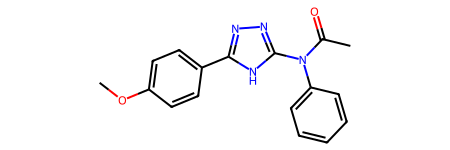

In [ ]:
m0 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[0])
m0

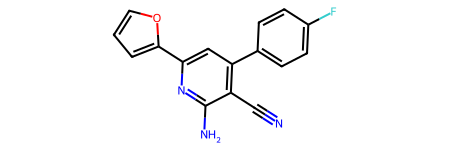

In [ ]:
m1 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[1])
m1

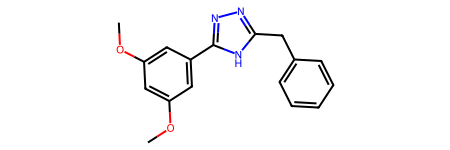

In [ ]:
m2 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[2])
m2

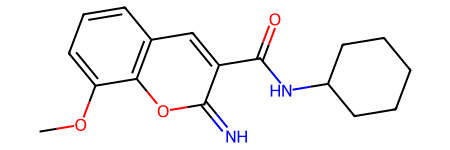

In [ ]:
m3 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[3])
m3

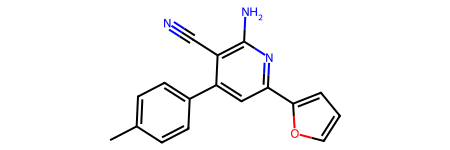

In [ ]:
m4 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[4])
m4

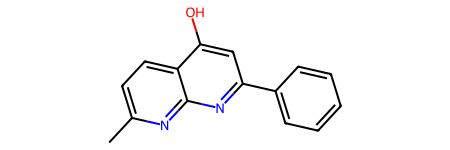

In [ ]:
m5 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[5])
m5

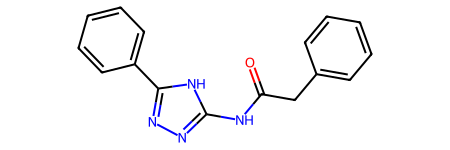

In [ ]:
m6 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[6])
m6

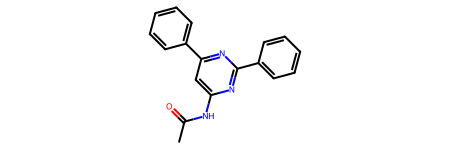

In [ ]:
m7 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[7])
m7

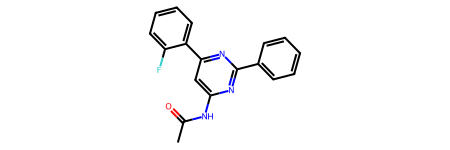

In [ ]:
m8 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[8])
m8

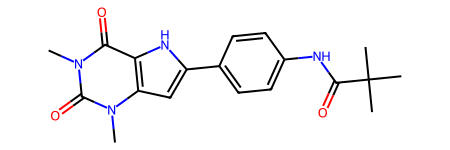

In [ ]:
m9 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[9])
m9

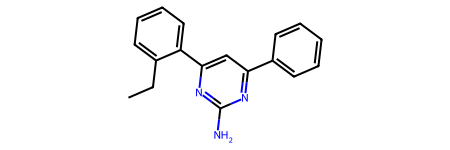

In [ ]:
m10 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[10])
m10

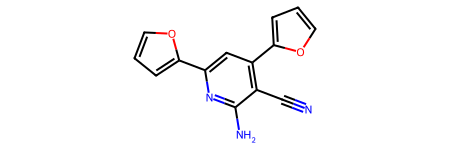

In [ ]:
m11 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[11])
m11

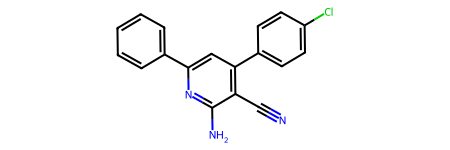

In [ ]:
m12 = Chem.MolFromSmiles(selected_hits_descr2['SMILES'].iloc[12])
m12